In [1]:
###########################################################
import numpy as np
random_seed = 37
np.random.seed(random_seed)
from tensorflow import set_random_seed
set_random_seed(random_seed)
###########################################################

import os
from keras.layers import Dense, GRU, LSTM, CuDNNGRU, CuDNNLSTM, Activation, LSTMCell, GRUCell, Masking, BatchNormalization, Dropout, GaussianNoise
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
# from keras_tqdm import TQDMNotebookCallback

from utils import plot_train_history, save_train_history, load_train_history

# Load training dataset
PAST_WINDOW_SIZE = 16
FUTURE_WINDOW_SIZE = 0
N_FEATURES = 6
# N_FEATURES = 12
seq_len = PAST_WINDOW_SIZE + FUTURE_WINDOW_SIZE
dataset_filename = f'/home/ICT2000/jondras/datasets/vra1/segmented_datasets/dataset_rus_{PAST_WINDOW_SIZE}pws_{FUTURE_WINDOW_SIZE}fws_{N_FEATURES}f.npz'
data = np.load(dataset_filename)
MASK_VALUE = data['MASK_VALUE']
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
print(f'Train examples per class: {np.unique(y_train, return_counts=True)}')
print(f'Val examples per class: {np.unique(y_val, return_counts=True)}')


Using TensorFlow backend.


Train examples per class: (array([0, 1]), array([17082, 17082]))
Val examples per class: (array([0, 1]), array([3750, 3750]))


In [2]:
# Model
# model = Sequential()
# model.add(GRU(20, input_shape = (seq_len, N_FEATURES), return_sequences=True))
# model.add(GRU(1, return_sequences = False))
# model.add(Activation('sigmoid'))
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# print(model.summary())

# GRU_units = [64, 64]
# GRU_units = [64]
GRU_units = [128]

model = Sequential()
# With masking
model.add(Masking(mask_value=MASK_VALUE, input_shape=(seq_len, N_FEATURES)))
# model.add(GaussianNoise(0.2))
model.add(GRU(GRU_units[0], return_sequences=False))#, dropout=0.2, recurrent_dropout=0.2))
# model.add(GaussianNoise(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())



# model = Sequential()
# # With masking
# model.add(Masking(mask_value=MASK_VALUE, input_shape=(seq_len, N_FEATURES)))
# model.add(GRU(GRU_units[0], return_sequences=False))
# # Without masking
# # model.add(GRU(GRU_units[0], input_shape=(seq_len, N_FEATURES), return_sequences=False))

# # model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 16, 6)             0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 16, 6)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               51840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 51,969
Trainable params: 51,969
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train
# model.fit(X_train, y_train, batch_size=10, epochs=5, verbose=0, callbacks=[TQDMNotebookCallback()])

n_epochs = 100
batch_size = 32

# Set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Checkpoint model weights and the model itself: at each epoch
model_type = f'BS_{GRU_units[0]}u_{PAST_WINDOW_SIZE}pws_{FUTURE_WINDOW_SIZE}fws_{N_FEATURES}f'
print(f'INFO:\n\t{model_type}\n\tbatch_size={batch_size}\n\tn_epochs={n_epochs}')
model_checkpoint_path_prefix = f'./checkpoints/{model_type}/'
if not os.path.exists(model_checkpoint_path_prefix):
    os.makedirs(model_checkpoint_path_prefix)
model_checkpoint_name = 'm_{epoch:04d}_{loss:.4f}_{val_loss:.4f}.hdf5'
model_checkpoint = ModelCheckpoint(model_checkpoint_path_prefix + model_checkpoint_name, monitor='val_loss', verbose=1, 
                                   save_best_only=True, save_weights_only=False, mode='auto', period=1)

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=n_epochs, verbose=1, 
                 callbacks=[
                     model_checkpoint,
                     early_stop
                 ], shuffle=True)

# Save training history
save_train_history(hist, model_type)

INFO:
	GN_128u_16pws_0fws_6f
	batch_size=32
	n_epochs=100
Instructions for updating:
Use tf.cast instead.
Train on 34164 samples, validate on 7500 samples
Epoch 1/100
34164/34164 [==============================] - 44s 1ms/step - loss: 0.4919 - acc: 0.7633 - val_loss: 0.4329 - val_acc: 0.7956

Epoch 00001: val_loss improved from inf to 0.43286, saving model to ./checkpoints/GN_128u_16pws_0fws_6f/m_0001_0.4919_0.4329.hdf5
Epoch 2/100
34164/34164 [==============================] - 43s 1ms/step - loss: 0.4249 - acc: 0.8118 - val_loss: 0.4384 - val_acc: 0.7947

Epoch 00002: val_loss did not improve from 0.43286
Epoch 3/100
34164/34164 [==============================] - 43s 1ms/step - loss: 0.4007 - acc: 0.8224 - val_loss: 0.4063 - val_acc: 0.8099

Epoch 00003: val_loss improved from 0.43286 to 0.40629, saving model to ./checkpoints/GN_128u_16pws_0fws_6f/m_0003_0.4007_0.4063.hdf5
Epoch 4/100
34164/34164 [==============================] - 43s 1ms/step - loss: 0.3890 - acc: 0.8294 - val_loss: 

In [32]:
aaa = np.full((16,6), MASK_VALUE)
# aaa = np.full((16,6), 0.)
aaa[-15:] = 0.0

model.predict(aaa.reshape(-1,16,6))

array([[0.00013991]], dtype=float32)

In [9]:
from keras.models import load_model
test_model_name = './checkpoints/masked_128u_16pws_0fws_6f/m_0016_0.1136_0.1953.hdf5'
model2 = load_model(test_model_name)
print(f'Loading model {test_model_name}')
print(model2.summary())

model2.predict(np.full((16,6), MASK_VALUE).reshape(-1,16,6))

Loading model ./checkpoints/masked_128u_16pws_0fws_6f/m_0016_0.1136_0.1953.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 16, 6)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               51840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 51,969
Trainable params: 51,969
Non-trainable params: 0
_________________________________________________________________
None


array([[0.42072278]], dtype=float32)

In [33]:
model2.predict(aaa.reshape(-1,16,6))

array([[0.0112114]], dtype=float32)

In [ ]:
# import importlib
# importlib.reload(utils)
# from utils import plot_train_history, save_train_history, load_train_history

128u_16pws_0fws_6f
	Min train loss: 0.2736513596719412 @epoch 26 	 Max train acc: 0.8910256410395984 @epoch 25
	Min valid loss: 0.34238864194552104 @epoch 16 	 Max valid acc: 0.8568 @epoch 23


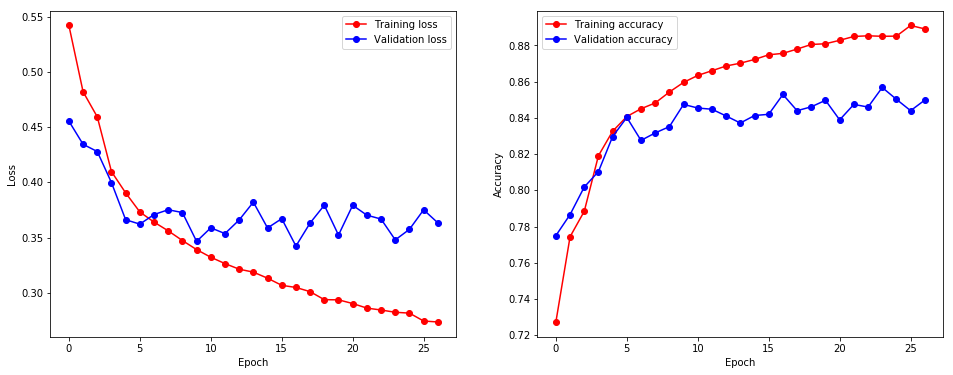

In [4]:
load_train_history('128u_16pws_0fws_6f')

X_masked_128u_16pws_0fws_12f
	Min train loss: 0.09807899797734576 @epoch 11 	 Max train acc: 0.9648753073340821 @epoch 11
	Min valid loss: 0.4110749321371317 @epoch 1 	 Max valid acc: 0.8221333333333334 @epoch 2


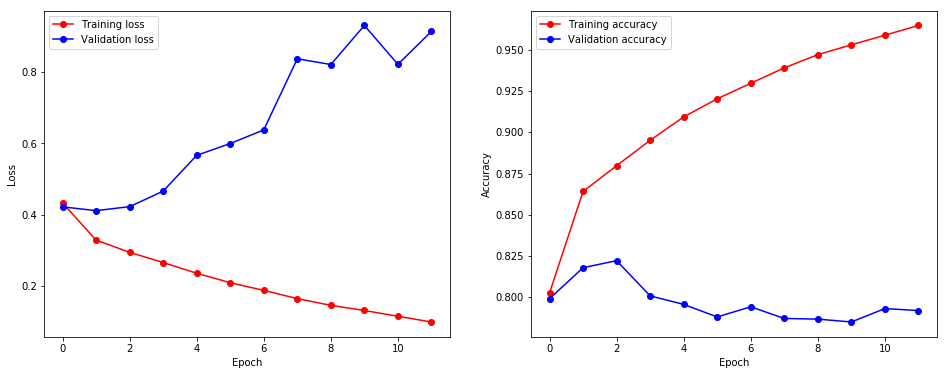

In [4]:
load_train_history('X_masked_128u_16pws_0fws_12f')

X_masked_128u_32pws_0fws_6f
	Min train loss: 0.06359773275478377 @epoch 12 	 Max train acc: 0.9788724105461394 @epoch 12
	Min valid loss: 0.39387283616572677 @epoch 2 	 Max valid acc: 0.8471074380165289 @epoch 1


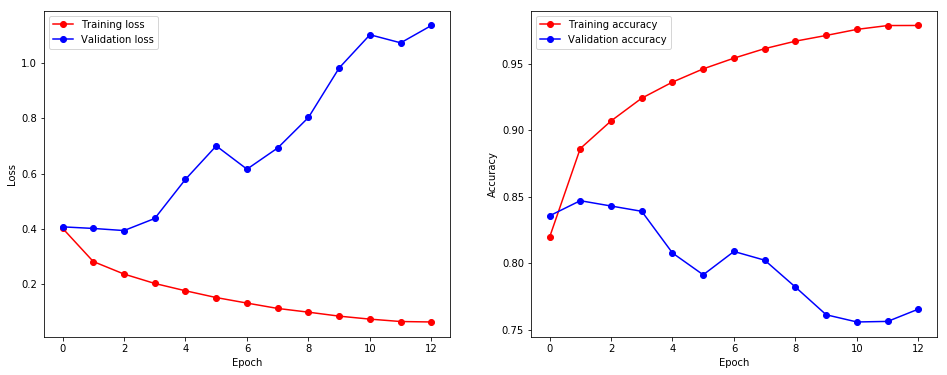

In [8]:
load_train_history('X_masked_128u_32pws_0fws_6f')

X_masked_128u_16pws_0fws_6f
	Min train loss: 0.11325415507881514 @epoch 12 	 Max train acc: 0.9578625235404896 @epoch 12
	Min valid loss: 0.41023744766733933 @epoch 2 	 Max valid acc: 0.8411228270502163 @epoch 3


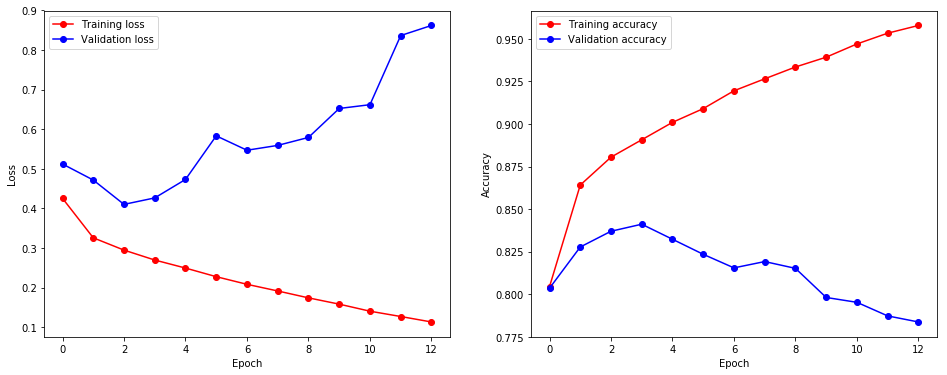

In [4]:
load_train_history('X_masked_128u_16pws_0fws_6f')

X_NONmasked_128u_16pws_0fws_6f
	Min train loss: 0.11651328420389283 @epoch 12 	 Max train acc: 0.9561558380414312 @epoch 12
	Min valid loss: 0.4138380219094534 @epoch 2 	 Max valid acc: 0.8412653177883184 @epoch 3


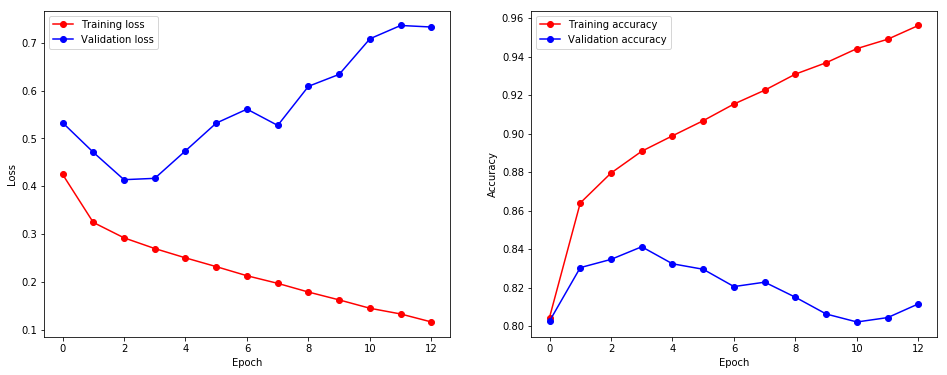

In [5]:
load_train_history('X_NONmasked_128u_16pws_0fws_6f')

In [8]:
# Evaluate
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

11702/11702 [==============================] - 4s 361us/step
Accuracy: 80.61%


In [ ]:
# k-fold cross-validation

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/